In [60]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from skimage.segmentation import slic

In [61]:
def mostrarHistograma(imagen, ax=None, etiqueta=None):
    imagen = np.uint8(imagen)  # Asegurarse de que la imagen esté en formato uint8
    histograma = cv2.calcHist([imagen], [0], None, [256], [0, 256])
    #histograma = histograma / histograma.max()  # Normalizar el histograma para que no se sobrepasen los límites
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(np.arange(256), histograma[:, 0],label=etiqueta)
    ax.set_xlim(0, 255)  # Asegurar que el eje X esté entre 0 y 255

def muestra(imagen):
    cv2.imshow('',imagen)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def analisisImagen(imagen):
    media = np.mean(imagen)
    desviacion = np.std(imagen)
    max = np.max(imagen)
    min = np.min(imagen)

    analisis = {
        'media': media,
        'std': desviacion,
        'min': min,
        'max': max,
        'contraste': max-min
    }

    return analisis

def modificarImagen(imagen,n):
    imagen_modificada = cv2.resize(imagen, (n, n), interpolation=cv2.INTER_AREA)    
    return np.uint8(imagen_modificada)

In [62]:
resolucion = 280

def prepro_rango_dinamico(nueva):
    #Ampliacion del rango dinamico
    nueva = np.float32(nueva)
    r1 = np.min(nueva)
    r2 = np.max(nueva)
    if r2-r1 < 100:
        nueva = 255 * (nueva - r1) / (r2 - r1)
    return np.uint8(nueva)

def prepro_ecualizacion_histograma(nueva):
    #Ecualizacion del histograma
    return cv2.equalizeHist(nueva)

def prepro_suavizado(nueva):
    H = np.ones((5, 5), dtype=np.float32) / 25
    nueva = cv2.filter2D(nueva, -1, H)
    return np.uint8(nueva)

def prepro_gamma(imagen, gamma):
    tabla = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(imagen, tabla)


In [63]:

def preprocesamiento(imagen): # seleccion automatica

    analisis = analisisImagen(imagen)
    if analisis['std'] > 50:
        imagen = prepro_suavizado(imagen)
        
    analisis = analisisImagen(imagen)
    if analisis['contraste'] < 200:
        imagen = prepro_rango_dinamico(imagen)
        imagen = prepro_ecualizacion_histograma(imagen)

    analisis = analisisImagen(imagen)
    if analisis['media'] > 180:
        imagen = prepro_gamma(imagen, 2.0)
    elif analisis['media'] < 70:
        imagen = prepro_gamma(imagen, 0.5)

    return modificarImagen(imagen,resolucion)


In [64]:
def extraccionCaracteristicasPuntosEspacial(imagen,num):
    mask = puntosSingulares(imagen)
    coordenadas = np.argwhere(mask == 1)

    h, w = imagen.shape
    hist = np.zeros((num, num))

    for y, x in coordenadas:

        grid_y, grid_x = y * num // h, x * num // w

        hist[grid_y, grid_x] += 1
    
    feature_vector = hist.flatten()
    feature_vector = feature_vector / np.linalg.norm(feature_vector)

    return feature_vector

def puntosSingulares(imagen):
    imagen = np.float32(imagen)
    dst = cv2.cornerHarris(imagen,2,3,0.04)
    dst = cv2.dilate(dst,None)
    mask = (dst>0.01*dst.max())
 
    return mask

In [65]:
def histogramasXceldas(imagen, num, E, phi):
    filas, columnas = imagen.shape
    histogramas = []
    for i in range(0, filas, num):
        for j in range(0, filas, num):
            celdaMag = E[i:i+num,j:j+num].flatten()
            celdaOri = phi[i:i+num,j:j+num].flatten()
            h = np.zeros(9)
            indices = celdaOri//(360//9)
            
            h = np.bincount(indices, weights=celdaMag, minlength=9)
            
            h = h/(np.sqrt(np.sum(h ** 2))+1e-6)
            histogramas.append(h)
    return histogramas

def gradiente(imagen):
    imagen_x = cv2.Sobel(imagen, cv2.CV_32F,1,0,ksize = 1)
    imagen_y = cv2.Sobel(imagen, cv2.CV_32F,0,1,ksize = 1)

    E = np.sqrt(np.power(imagen_x, 2) + np.power(imagen_y, 2))
    Phi = np.arctan2(imagen_y, imagen_x)
    Phi = np.rad2deg(Phi)

    return np.uint8(E), np.uint8(Phi)

def extraccionCaracteristicas(imagen, num):
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    caracteristicas = np.concatenate(histogramasXceldas(imagen, num, E, phi))
    return caracteristicas

In [66]:
def cargar_imagenes_y_labels(pathfile, preprocesamiento, extractor):
    X, y = [], []
    clases = ['cat', 'dog']

    for clase in clases:
        ruta = os.path.join(pathfile, clase)
        archivos = glob.glob(os.path.join(ruta, "*.jpg"))
        for archivo in archivos:
            imagen = cv2.imread(archivo, 0)
            imagen = preprocesamiento(imagen)
            caracteristicas = extractor(imagen,16)
            X.append(caracteristicas)
            y.append(0 if clase == 'cat' else 1)

    return np.array(X), np.array(y)

In [67]:
mejor_combinacion = [preprocesamiento, extraccionCaracteristicasPuntosEspacial]
mejor_modelo = make_pipeline(StandardScaler(), MLPClassifier(max_iter=200, random_state=41))
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,)],
    'mlpclassifier__activation': ['relu']
}
def evaluar(dataset_path):

    # Cargar datos de entrenamiento desde la carpeta train
    X_train, y_train = cargar_imagenes_y_labels(os.path.join(dataset_path, 'train'), mejor_combinacion[0], mejor_combinacion[1])
    # Cargar datos de prueba desde la carpeta test
    X_test, y_test = cargar_imagenes_y_labels(os.path.join(dataset_path, 'test'), mejor_combinacion[0], mejor_combinacion[1])

    # Entrenar modelo
    grid_search = GridSearchCV(mejor_modelo, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = grid_search.best_estimator_.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")

evaluar('dataset/cat_dog_500')

Accuracy: 0.7950


In [68]:
for i in range(200,300,10):
    resolucion = i
    print(i)
    evaluar('dataset/cat_dog_500')
resolucion = 290

200
Accuracy: 0.7600
210
Accuracy: 0.7800
220
Accuracy: 0.7750
230
Accuracy: 0.7850
240
Accuracy: 0.7700
250
Accuracy: 0.7850
260
Accuracy: 0.8050
270
Accuracy: 0.7700
280
Accuracy: 0.8100
290
Accuracy: 0.7950


In [71]:
def preprocesamiento_rango_suavizado(imagen):
    imagen2 = modificarImagen(imagen,resolucion)
    imagen2 = prepro_rango_dinamico(imagen2)
    #imagen2 = prepro_ecualizacion_histograma(imagen2)
    imagen2 = prepro_suavizado(imagen2)
    return imagen2

In [75]:
mejor_combinacion = [preprocesamiento_rango_suavizado, extraccionCaracteristicasPuntosEspacial]
mejor_modelo = make_pipeline(StandardScaler(), MLPClassifier(max_iter=200, random_state=41))
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,)],
    'mlpclassifier__activation': ['relu']
}
def evaluar(dataset_path):

    # Cargar datos de entrenamiento desde la carpeta train
    X_train, y_train = cargar_imagenes_y_labels(os.path.join(dataset_path, 'train'), mejor_combinacion[0], mejor_combinacion[1])
    # Cargar datos de prueba desde la carpeta test
    X_test, y_test = cargar_imagenes_y_labels(os.path.join(dataset_path, 'test'), mejor_combinacion[0], mejor_combinacion[1])

    # Entrenar modelo
    grid_search = GridSearchCV(mejor_modelo, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = grid_search.best_estimator_.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    return acc


In [78]:
lista_acc = []
for i in range(100,500,50):
    resolucion = i
    lista_acc.append(evaluar('dataset/cat_dog_100'))

resolucion = 200 #vuelta a la normalidad

Accuracy: 0.6750
Accuracy: 0.7500
Accuracy: 0.6750
Accuracy: 0.7500
Accuracy: 0.7750
Accuracy: 0.7250
Accuracy: 0.7250
Accuracy: 0.7500


Text(0, 0.5, 'Precisión')

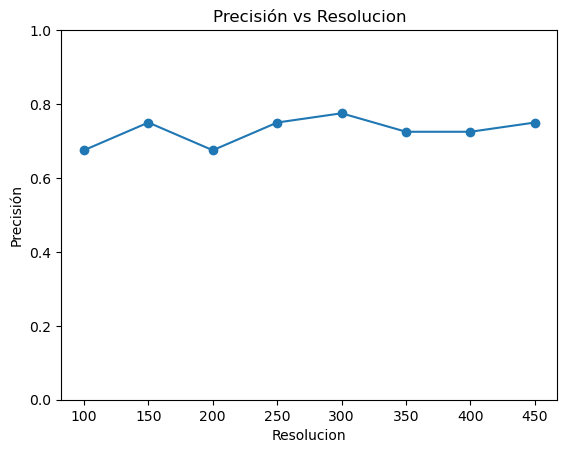

In [79]:
fig, ax = plt.subplots()
x = range(100,500,50)
# Graficar los datos
ax.plot(x, lista_acc, marker='o')

# Configurar los límites del eje y para que incluyan 0 a 1
ax.set_ylim(0, 1)

# Etiquetas y título
ax.set_title("Precisión vs Resolucion")
ax.set_xlabel("Resolucion")
ax.set_ylabel("Precisión")